In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import sys
from tqdm import tqdm
import pickle
from pathlib import Path
import bilby

# Add module
sys.path.append('../../modules')
from compute_omega import sample_dict_compute_injected_omega
from gwBackground_module import *

from constants import *

from pygwb.constants import H0
import equations
import redshiftPrior

from loguru import logger

import lal

# needed to speed up waveform calculations
lal.swig_redirect_standard_output_error(False)
import montecarlo

# Helper Functions

# Parameters

In [2]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Frequency Parameters
fmax = 3000
fref = 25

fs = 1024

# Data Simulation Parameters
T_obs = .1 # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
N_segs = 1 # number of data segments to generate
sampling_frequency = 1024 # sampling rate (in Hz)
num_iterations = 12 # number of iterations to average Omega(f) over

z_max = 20

N_inj = 100_000 # number of injections that we will then reweight

In [3]:
# Standard Prior Dictionary
# Prior dictionary for priors we *want* to calculate omega_gw for
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.8, minimum=BBH_min, maximum=BBH_max)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del priors['luminosity_distance']
del priors['chirp_mass']

# "Reference" prior dictionary
ref_priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
# uniform_priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
ref_priors['mass_1'] = bilby.core.prior.Uniform(minimum=BBH_min, maximum=BBH_max)
ref_priors['mass_ratio'] = bilby.core.prior.Uniform(minimum=0, maximum=1)
ref_priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
ref_priors['chi_1'] = 0
ref_priors['chi_2'] = 0
ref_priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp,
                                                                       minimum=0, maximum=z_max, name='redshift')
ref_priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del ref_priors['luminosity_distance']
del ref_priors['chirp_mass']

17:28 bilby INFO    : Using aligned spin prior
17:28 bilby INFO    : No prior given, using default BBH priors in /Users/patrickmeyers/opt/anaconda3/envs/surf_2023_omega_gw/lib/python3.10/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.
17:28 bilby INFO    : Using aligned spin prior
17:28 bilby INFO    : No prior given, using default BBH priors in /Users/patrickmeyers/opt/anaconda3/envs/surf_2023_omega_gw/lib/python3.10/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [4]:
# Calculate number of injections
def calculate_num_injections(T_obs, priors):
    zs, p_dz = priors['redshift']._get_redshift_arrays()
    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
    total_sum = np.sum(np.diff(zs) * p_dz_centers)
    N = T_obs * total_sum
    return N

zs, p_dz = priors['redshift']._get_redshift_arrays()
print(zs)
N = calculate_num_injections(T_obs, priors).value
print(N)

[0.0000000e+00 1.0006003e-02 2.0012006e-02 ... 1.9981988e+01 1.9991994e+01
 2.0002000e+01]
4856.7039176108765


# Gridded Method

## Calculate Gridded Method

In [6]:
# Gridded Method
# Set up OmegaGW object
inspiralOnly = False
m1_min = BBH_min
m1_max = BBH_max
m2_min = BBH_min
m2_max = BBH_max
minimum_component_mass = BBH_min
maximum_component_mass = BBH_max


## load callister merger rate info, construct his merger rate version

In [10]:
redshift_data = np.loadtxt('./callister_redshift_examples/redshiftData.dat')
rateData = np.load('./callister_redshift_examples//delayedRateData.npy', allow_pickle=True,encoding='latin1')[()]
# rateData = np.load('../code/delayedRateData.npy',allow_pickle=True,encoding='latin1')[()]


if Path('callister_omg_object.pickle').exists():
    omg = pickle.load(open('callister_omg_object.pickle', 'rb'))
else:
    omg = OmegaGW_BBH(minimum_component_mass, maximum_component_mass, zs)
    pickle.dump(omg, open('callister_omg_object.pickle', 'wb'))

In [11]:
zsMerger = rateData['zs']                       # Grid of possible merger redshifts, between 0<z<10 (size M)
tdelays = rateData['tds']                       # Grid of possible delay times between binary formation and merger, between 0<t_d<13.5 Gyr (size N)
formationRates = rateData['formationRates']     # MxN array of *formation* redshifts z_form(z_merge,t_d) implied by each combination of z_merge and time delay
zsFormation = rateData['formationRedshifts']  
tdMin = 0.02
dpdt = np.power(tdelays,-1)
dpdt[tdelays<tdMin] = 0.

# Multiply to get the merger rate!
# Note that this is unnormalized. It gives us only the *shape* of the merger rate as a function of redshift.
# We will need the local merger rate from Step 1 above to correctly normalize this quantity.
mergerRate = formationRates.dot(dpdt)


## Compare our merger rate to his

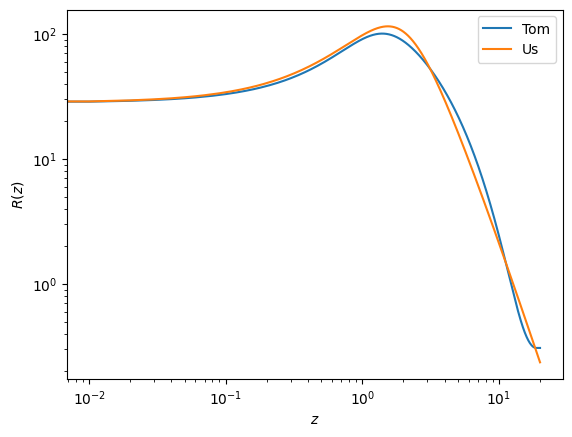

In [12]:
plt.loglog(omg.ref_zs, mergerRate / mergerRate[0] * R0, label='Tom')
rate = priors['redshift']._get_rate_vs_redshift(omg.ref_zs)
plt.loglog(omg.ref_zs, rate * 1e9, label='Us')
plt.xlabel("$z$")
plt.ylabel("$R(z)$")
plt.legend()
# plt.loglog(
plt.show()

## compare mass distributions

In [13]:
# Calculate merger rate
# mergerRate = equations.get_R_array(zs, alpha, beta, zp, R0)
# mergerRate2 = equations.get_R_array(omg.ref_zs, alpha, beta, zp, R0)
rate = priors['redshift']._get_rate_vs_redshift(omg.ref_zs)
freqs_TC = np.arange(0, 512.5, 0.5)
# print(mergerRate.shape)
# print(omg.ref_zs.shape)
OmegaGW_TC_orig = omg.eval(R0, mergerRate, freqs_TC)

# Calculate probability grid
# Priors defined in (m1, q) space
probs = np.empty((omg.m1s_2d.shape[0], omg.qs_2d.shape[1])) # initialize array
for i in tqdm(range(omg.m1s_2d.shape[0])): # for each m1
    for j in range(omg.qs_2d.shape[1]): # for each q
        prob = priors.prob({'mass_1':omg.m1s_2d[i][j], 'mass_ratio':omg.qs_2d[i][j]}) # calculate probability
        probs[i][j] = prob # insert probability into probability array
probs = probs*(omg.Mtots_2d/(1. + omg.qs_2d)) # multiply by the Jacobian

# Limit probabilities to physical masses
probs[omg.m1s_2d < m1_min] = 0
probs[omg.m1s_2d > m1_max] = 0
probs[omg.m2s_2d < m2_min] = 0
probs[omg.m2s_2d > m2_max] = 0

# Normalize probabilities
probs /= np.sum(probs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 148.22it/s]


In [14]:
R0 = 28.3
mMin = 5.
lmbda1 = -2.3
lmbda2 = -6.
m0 = 35.
bq = 1.5

omg.setProbs(mMin, lmbda1, lmbda2, m0, bq)

/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/Projects/SURF2023/repositories/astrophysical_gwb/notebooks/sgwb_calculation/../../modules/gwBackground_module.py:267: RuntimeWarning: divide by zero encountered in divide
  probs_m2 = (1.+bq)*np.power(self.m2s_2d,bq)/(np.power(self.m1s_2d,1.+bq)-mMin**(1.+bq))


/var/folders/pw/q58shg_d4vz37qn56ds0zjm40000gn/T/ipykernel_78495/1035799795.py:1: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(omg.m1s_2d, omg.m2s_2d, np.log(probs/np.max(probs)), vmin=-12, vmax=0)


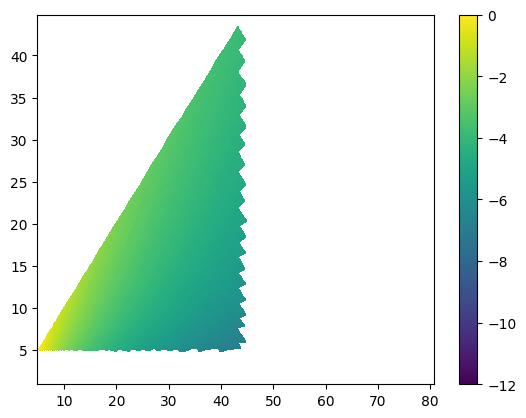

/var/folders/pw/q58shg_d4vz37qn56ds0zjm40000gn/T/ipykernel_78495/1035799795.py:4: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(omg.m1s_2d, omg.m2s_2d, np.log(omg.probs / np.max(omg.probs)))


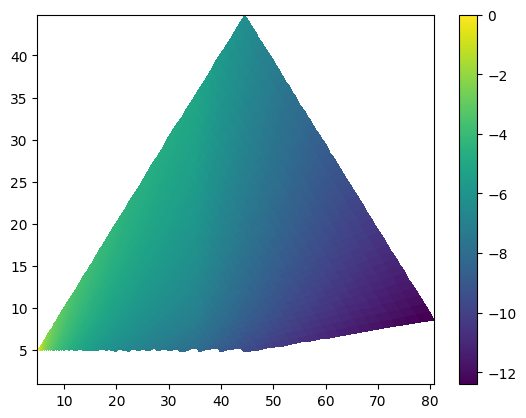

In [15]:
plt.pcolormesh(omg.m1s_2d, omg.m2s_2d, np.log(probs/np.max(probs)), vmin=-12, vmax=0)
plt.colorbar()
plt.show()
plt.pcolormesh(omg.m1s_2d, omg.m2s_2d, np.log(omg.probs / np.max(omg.probs)))
plt.colorbar()
plt.show()


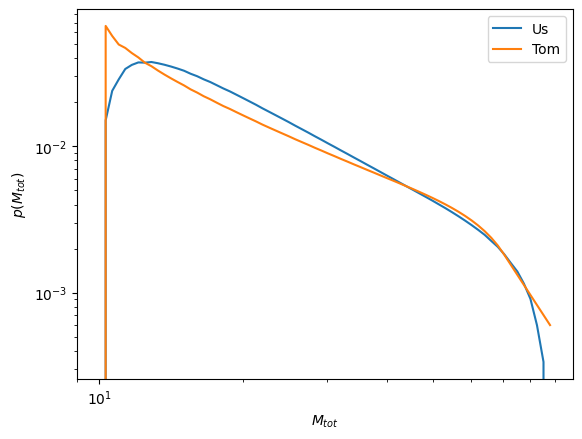

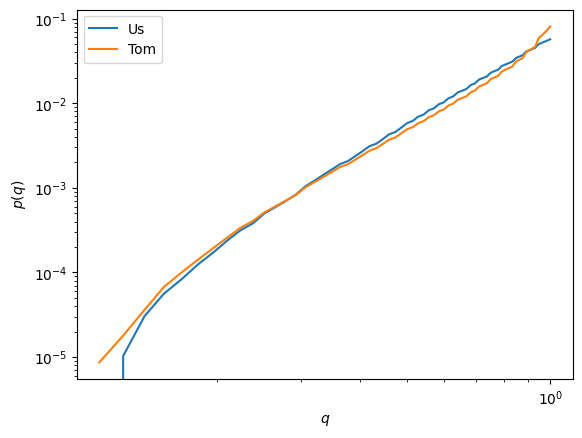

In [16]:
plt.plot((omg.m2s_2d + omg.m1s_2d)[0, :], np.sum(probs, axis=0), label='Us')
plt.plot((omg.m2s_2d + omg.m1s_2d)[0, :], np.sum(omg.probs, axis=0), label='Tom')
plt.yscale("log")
plt.xscale("log")
plt.ylabel("$p(M_{tot})$")
plt.xlabel("$M_{tot}$")
plt.legend()
plt.show()

plt.plot(omg.qs_2d[:, 0], np.sum(probs, axis=1), label='Us')
plt.plot(omg.qs_2d[:, 0], np.sum(omg.probs, axis=1), label='Tom')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$q$")
plt.legend()
plt.ylabel("$p(q)$")
plt.show()

# print(omg.m1s_2d)